# Identifying A Common Point of Compromise

## Background 
A common point of compromise is a breach point used by fraudsters to collect card data. This can be a physical location, such as a skimmer fitted on an ATM; alternatively, a virtual breach, such as data stolen from a merchant’s database of transactions, can be the point of compromise. Identifying common points of compromise is important for commercial banks, as it allows them to block or monitor other accounts at risk of fraud.
Exploitation of a common point of compromise typically occurs in a two-stage process. 
In the first stage of the compromise, account details are harvested from the compromise point. In the second stage of the compromise, these compromised account details are used to make fraudulent transactions. There is typically a delay of several days between harvest and exploit, as it takes time for a fraudster to process the data that they have harvested.

## Task
In this task we are given a dataset of transactions from a 30-day period and we are told that one of the merchants in the dataset was compromised by the fraudsters. The customer accounts that transacted with that merchant during that period are at risk of fraud.

I will use the provided dataset to answer the questions:
- What is the identity of the compromised merchant?
- What are the dates of the compromise? (When the fraudsters harvested the data)
- What are the dates of the exploitation? (When the fraudsters used the stolen data to perform fraudulent transactions)

In general, my approach will involve the following steps:
   1. Identify the dates of exploit of the defrauded data. 
   2. Based on the dates of exploit, identify the set of defrauded accounts.
   3. Identify the potential compromised merchant based on the total number of 
      defrauded accounts transacted with.
   4. Check if the number of defrauded accounts that transacted with the suspected merchant
      peaks in some time before the exploitation dates. 
   5. If we find such a peak it will prove the merchant to be compromised and the days
      of the peak will be our dates of the compromise.

In [1]:
import pandas as pd
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

# Dataset

Our dataset is given in a single .csv file which contains the following columns:
- account (unique id of the customer's account)
- date (date of the transaction)
- fraud (boolean flag for fraud)
- merchant (unique id of the merchant)

In [2]:
# convert the data to pandas DataFrame.
data = pd.read_csv("TaskData.csv")
data

,account,date,fraud,merchant
0,A0,2015-01-01,False,M98
1,A0,2015-01-01,False,M50
2,A0,2015-01-01,False,M55
3,A0,2015-01-01,False,M14
4,A0,2015-01-01,False,M10
...,...,...,...,...
89846,A998,2015-01-30,False,M70
89847,A998,2015-01-30,False,M67
89848,A999,2015-01-30,False,M59
89849,A999,2015-01-30,False,M42


In [3]:
data.describe()

,account,date,fraud,merchant
count,89851,89851,89851,89851
unique,1000,30,2,100
top,A831,2015-01-12,False,M8
freq,121,3081,88503,998


The dataset contains 89851 transactions between 100 different merchants and 1000 different accounts. 

In [4]:
data['date'].value_counts()

2015-01-12    3081
2015-01-01    3079
2015-01-08    3066
2015-01-22    3057
2015-01-15    3046
2015-01-11    3029
2015-01-19    3027
2015-01-04    3025
2015-01-09    3024
2015-01-27    3022
2015-01-16    3018
2015-01-28    3011
2015-01-26    3008
2015-01-21    3006
2015-01-24    3005
2015-01-10    2999
2015-01-02    2999
2015-01-23    2997
2015-01-06    2993
2015-01-14    2981
2015-01-25    2975
2015-01-03    2958
2015-01-05    2957
2015-01-13    2955
2015-01-07    2954
2015-01-30    2953
2015-01-18    2937
2015-01-17    2910
2015-01-29    2906
2015-01-20    2873
Name: date, dtype: int64

The transactions are roughly evenly distributed over the month. 

In [5]:
data['merchant'].value_counts()

M8     998
M61    966
M83    956
M87    951
M48    946
      ... 
M86    843
M14    842
M42    839
M17    837
M98    830
Name: merchant, Length: 100, dtype: int64

Although M8 is the most popular merchant, its number of transactions is not significantly higher than for other merchants, and in general the transactions seem to be roughly evenly distributed accross each merchant.

In [6]:
data['account'].value_counts()

A831    121
A86     120
A425    117
A559    116
A139    115
       ... 
A798     66
A412     64
A289     63
A121     63
A292     61
Name: account, Length: 1000, dtype: int64

Number of transactions performed by each account ranges from 61 to 121.

# Dates of Exploit

First, we'll try to identify the potential dates of exploit of the defrauded data. We must find days when an unusually high number of fraudulent transactions took place.

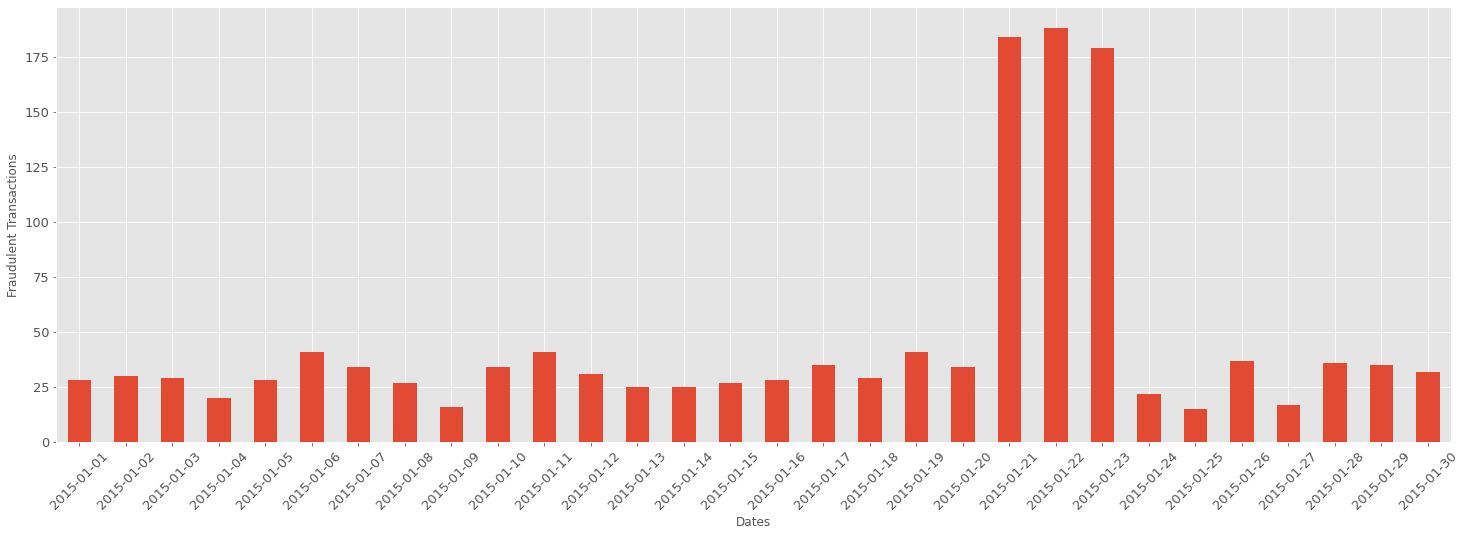

In [23]:
# sum the fraudulent transactions on each day
fraud_sum = data.groupby('date')['fraud'].sum().rename('frauds_sum')

# create a bar plot visualizing the number of 
# fraudulent transactions on each day
ax = fraud_sum.plot.bar(figsize=(25,8), fontsize=13, xlabel='Dates', ylabel='Fraudulent Transactions', rot=45)

In [25]:
# convert to DataFrame with two columns:
# 'date' and 'frauds_sum'
fraud_sum = fraud_sum.reset_index()

# boolean mask to filter the transactions
mask = (fraud_sum['date'] >= '2015-01-21') & (fraud_sum['date'] <= '2015-01-23')

# sum of fraud transactions
# between 21-01-2015 and 23-01-2015
sum_21_to_23 = fraud_sum.loc[mask]['frauds_sum'].sum()

# sum of all fraud transactions
sum_all = fraud_sum['frauds_sum'].sum()

# ratio of two sums
r = round((sum_21_to_23 / sum_all) * 100)

print('{} %'.format(r))

41 %


We can observe a significant peak in the number of fraudulent transactions that took place from 21-01-2015 to 23-01-2015 (41% of all the frauds were registered during these three days). It let us assume that this are the dates of the exploitation of the previously harvested data.

# Defrauded Accounts

Our next step will be identifying the defrauded accounts, i.e. the accounts which were stolen from the common point of compromise. We will select all the unique accounts which performed the fraudulent transactions on days from 21-01-2015 to 23-01-2015. We must keep in mind that some of these transactions could be other kind of frauds unrelated to our task (e.g. using a lost card). Nevertheless, still the majority of them should be performed by the accounts which data were harvested from the compromised merchant.

In [26]:
# boolean mask to filter the transactions
mask = (data['date'] >= '2015-01-21') & (data['date'] <= '2015-01-23') & (data['fraud'] == True)

# all the fraudulent transactions 
# between 21-01-2015 and 23-01-2015
fraud_transactions = data.loc[mask]
fraud_transactions

,account,date,fraud,merchant
59937,A8,2015-01-21,True,M99
59938,A8,2015-01-21,True,M73
59939,A8,2015-01-21,True,M47
59940,A8,2015-01-21,True,M0
59941,A8,2015-01-21,True,M41
...,...,...,...,...
68819,A952,2015-01-23,True,M86
68820,A952,2015-01-23,True,M88
68821,A952,2015-01-23,True,M94
68941,A992,2015-01-23,True,M13


In [27]:
# select all the accounts that performed fraudulent
# transactions during the dates of exploit 
defrauded_acc = fraud_transactions["account"].drop_duplicates()
print(defrauded_acc)
defrauded_acc = defrauded_acc.values.tolist()

59937      A8
59969     A16
60015     A32
60030     A37
60038     A40
         ... 
68270    A771
68630    A886
68796    A942
68941    A992
68964    A998
Name: account, Length: 148, dtype: object


148 different accounts performed the fraudulent transactions from 21-01-2015 to 23-01-2015.

# Compromised Merchant

Having obtained the list of the defrauded accounts we can identify the compromised merchant. We know that 'the common point of compromise can be identified when an unusually high number of defrauded accounts transacted with the same merchant, some time before fraudulent transactions were seen for those accounts'. Therefore, we can use the following approach: inspect the transactions performed by the defrauded accounts which took place before 21-01-2015 and count with how many of these accounts each merchant transacted. The merchant with the highest 'account count' is probably the compromised one.

In [28]:
# select transcations of the defrauded accounts before 21-01-2015
mask = (data['date'] < '2015-01-21') & (data['account'].isin(defrauded_acc))

bfr_exploit_trans = data.loc[mask]
bfr_exploit_trans

,account,date,fraud,merchant
24,A6,2015-01-01,False,M6
25,A6,2015-01-01,False,M91
26,A6,2015-01-01,False,M64
27,A6,2015-01-01,False,M88
30,A8,2015-01-01,False,M46
...,...,...,...,...
59895,A991,2015-01-20,False,M60
59896,A992,2015-01-20,False,M41
59897,A992,2015-01-20,False,M44
59898,A992,2015-01-20,False,M42


In [29]:
# count with how many defrauded accounts has each merchant transacted
acc_per_mrchnt = bfr_exploit_trans.groupby('merchant')['account'].nunique().sort_values(ascending=False)
acc_per_mrchnt.head(20)

merchant
M18    91
M8     78
M61    77
M94    76
M53    75
M76    75
M92    74
M31    74
M48    74
M21    73
M68    73
M79    73
M22    73
M0     73
M95    73
M17    73
M85    72
M25    72
M91    72
M57    71
Name: account, dtype: int64

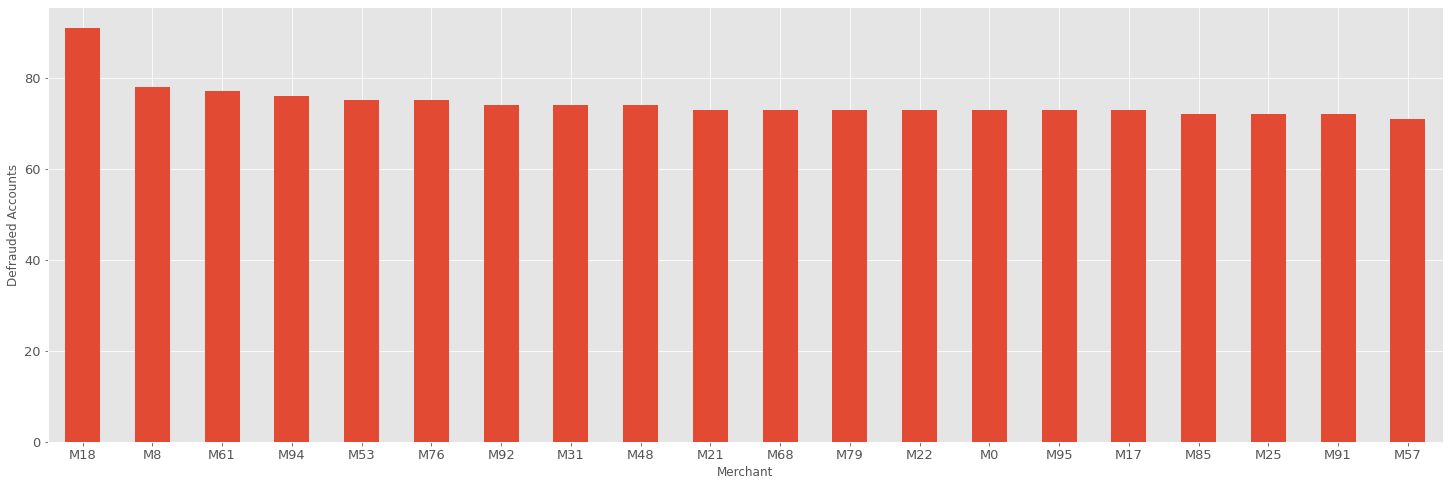

In [30]:
# plot data
ax = acc_per_mrchnt.head(20).plot.bar(figsize=(25,8), fontsize=13, xlabel='Merchant', ylabel='Defrauded Accounts', rot=0)

The M18 transacted with 91 defrauded accounts, which is 13 more than the second most popular merchant M8. If we look at the top 20, we can see that the difference between the consecutive merchants is normally equal to 1. It indicates an anomaly, and let us suspect that M18 is the compromised merchant. To prove that we must show that transactions between these accounts and M18 were cumulated in some period, a few days before the exploitation started.

# Dates of Harvest

To indicate the dates of the compromise we will simply count with how many defrauded accounts the M18 transacted on each day. The dates with the largest number should be the days we are looking for.

In [31]:
# all transactions between defrauded accounts and M18 which took place before 21-01-2015
bfr_exploit_m18_trans = bfr_exploit_trans[bfr_exploit_trans['merchant'] == 'M18']

# count with how many defrauded accounts M18 transacted on each day
m18_acc_per_day = bfr_exploit_m18_trans.groupby('date')['account'].nunique()
m18_acc_per_day

date
2015-01-01     2
2015-01-02     4
2015-01-03     2
2015-01-04     4
2015-01-05     5
2015-01-06     2
2015-01-07     3
2015-01-08     5
2015-01-09     3
2015-01-10     3
2015-01-11     3
2015-01-12     5
2015-01-13     6
2015-01-14     4
2015-01-15    22
2015-01-16    32
2015-01-17     1
2015-01-19     3
2015-01-20     6
Name: account, dtype: int64

Note that the value for 2015-01-18 is missing, which means no transactions with any of the defrauded accounts were registered on this day.

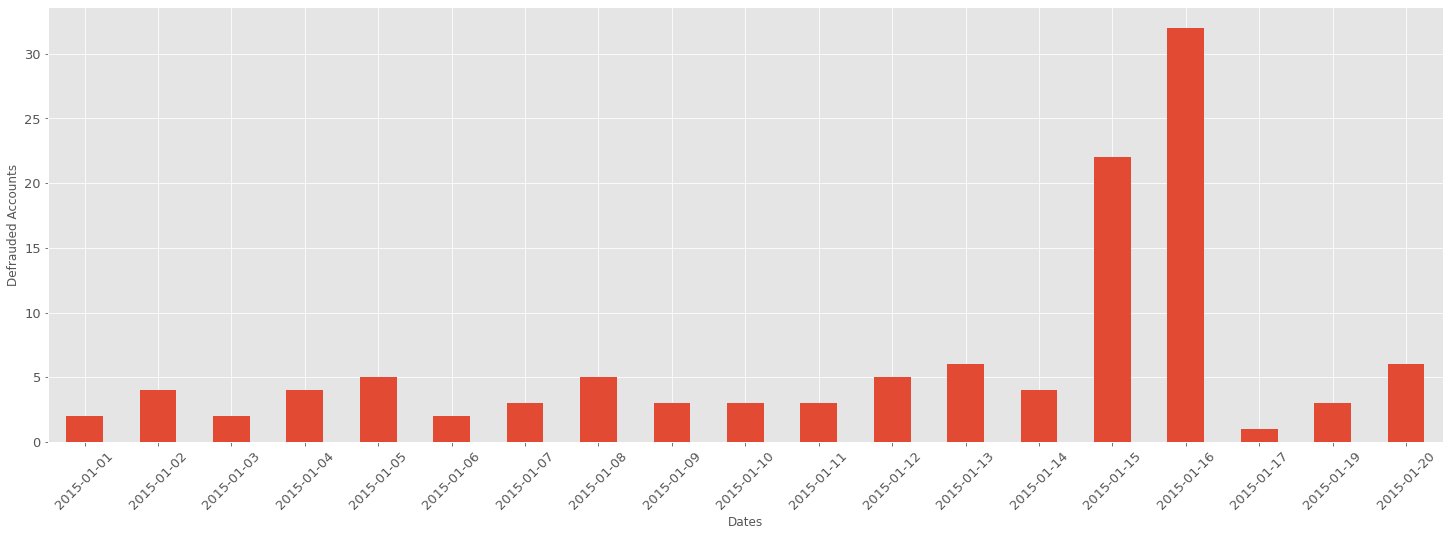

In [32]:
# plot data
ax = m18_acc_per_day.plot.bar(x='date', figsize=(25,8), fontsize=13, xlabel='Dates', ylabel='Defrauded Accounts', rot=45)

The unusually high number of defrauded accounts transacted with M18 merchant on 15-01-2015 and 16-01-2015. Also, there is a delay of 5 days between the second date and the previously identified start date of the exploitation. It matches the typical two-stage pattern of the compromise described in the task brief. Therefore, we can conclude that M18 merchant was compromised and fraudsters harvested the data on 15-01-2015 and 16-01-2015.

# Alternative Method

The initial method of finding the compromised merchant and the dates of exploit can be reduced to one single step. Before, we first identified the potential compromised merchant by looking at the TOTAL count of all the defrauded accounts which transacted with each merchant before the exploitation dates. Next, we checked if transactions between these accounts and suspected merchant were cumulated in some short period. However, if we were given a scenario where some merchant had transacted with the largest number of such accounts, but this transactions were evenly distributed between all days, we would have to inspect the next most popular merchant. 
Instead, for each day, we can select the 'top merchant' (i.e. merchant which transacted with the highest number of defrauded accounts on a particular day). It let us identify, right away, when the largest number occured and which merchant was associated with it.

In [35]:
# for each day and merchant, count the number of defrauded accounts
# the merchant transacted with 
acc_per_day_mercht = bfr_exploit_trans.groupby(['date', 'merchant'])['account'].nunique().sort_values(ascending=False).rename('accounts_sum')
acc_per_day_mercht = acc_per_day_mercht.reset_index()

# it will leave only the top values for each day
# as the dates are sorted in the descending order
acc_per_day_mercht.drop_duplicates('date', inplace=True)

acc_per_day_mercht.set_index(['date', 'merchant'], inplace=True)
acc_per_day_mercht.sort_index(inplace=True)
acc_per_day_mercht

,,accounts_sum
date,merchant,
2015-01-01,M91,9
2015-01-02,M65,9
2015-01-03,M76,9
2015-01-04,M91,11
2015-01-05,M53,9
2015-01-06,M22,12
2015-01-07,M62,10
2015-01-08,M51,10
2015-01-09,M95,11


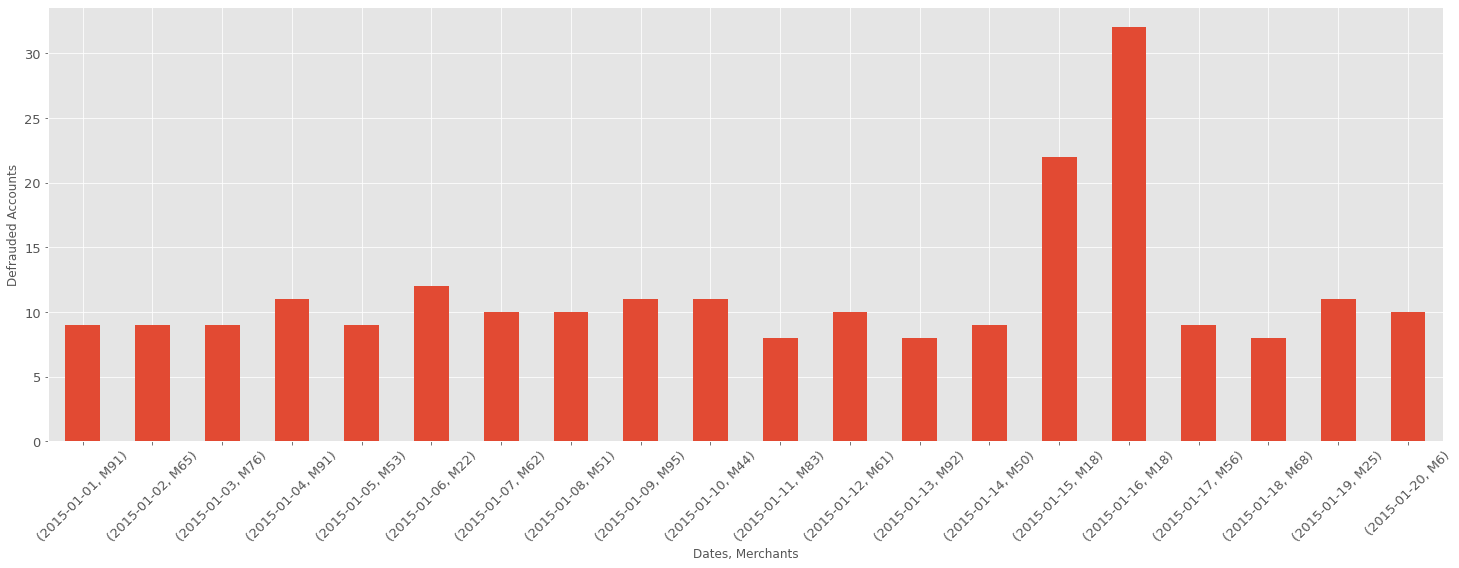

In [17]:
# plot data
ax = acc_per_day_mercht.plot.bar(figsize=(25,8), fontsize=13, xlabel='Dates, Merchants', ylabel='Defrauded Accounts', legend=False, rot=45)

Merchant M18 transacted with an unusually high number of defrauded accounts on 15-01-2015 and 16-01-2015, which let us suspect that the merchant was compromised and the data were harvested during these days.

# Answer
- Identity of the compromised merchant: M18
- Dates of the compromise: 15-01-2015 and 16-01-2015
- Dates of the exploitation: 21-01-2015, 22-01-2015 and 23-01-2015

# Conclusions

My solution was based on finding anomalies in the dataset and it worked reasonably well as the values related to the common point of compromise were easily distinguishable from the other data (e.g. very high number of frauds during the exploitation dates or significantly larger total number of defrauded accounts that transacted with the compromised merchant). I didn't find any other potential candidates for the compromised merchants, dates of compromise or dates of exploit.